In [ ]:
#%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import math
from pylab import *
from scipy.interpolate import interp1d
import time
from scipy.integrate import simps
import csv
from my_functions import *

In [ ]:
filepath = './JPAS_Transmission_Curves_20170316/minijpas.Filter.csv'
filters_tags = []

with open(filepath, mode='r') as csvfile:
    rdlns = csv.reader(csvfile, delimiter=',')
    
    next(rdlns, None)
    next(rdlns, None)
    
    for line in rdlns:
        filters_tags.append(line[1])
        
filters_tags[0] = 'J0348'

In [ ]:
filters_w = []
filters_trans = []

for tag in filters_tags:
    
    filename = './JPAS_Transmission_Curves_20170316/JPAS_'+tag+'.tab'
    f = open(filename, mode='r')
    lines = f.readlines()[12:]
    w = []
    trans = []
   
    for l in range(len(lines)):
        w.append(float(lines[l].split()[0]))
        trans.append(float(lines[l].split()[1]))
        
    filters_w.append(w)
    filters_trans.append(trans)
    
        
tcurves = {
    "tag"  :  filters_tags,
    "w"    :  filters_w ,
    "t"    :  filters_trans
}

Import the mocks

In [ ]:
f_name = 'Source_cats/Source_cat_LAE_15deg_uniform.npy'
mock = np.load( f_name, allow_pickle=True ).item()

In [ ]:
# Import errors
errors = np.load('npy/median_errors.npy')

In [ ]:
w_central = []

for fil in range(0,len(tcurves['tag'])):
    w_c = sum(np.array(tcurves['w'][fil])*np.array(tcurves['t'][fil])) \
           / sum(tcurves['t'][fil])
    w_central.append(w_c)

In [ ]:
def photo(mock_number): # Makes the photometry of mock #mock_number
    
    photo_len = len(tcurves['tag'])
    photo = np.zeros(photo_len)      # Initialize pm vector
    
    for fil in range(0,photo_len):   # For each filter
        
        w = np.array(tcurves['w'][fil])
        t = np.array(tcurves['t'][fil])
        
        w_Arr = mock['w_Arr']
        
        sed = np.interp(w_Arr, w, t)*mock['SEDs'][mock_number]
                
        sed_int = simps(w_Arr*sed,w_Arr)
        t_int   = simps(w*t,w)
        
        err = np.random.normal()*errors[fil]
        
        photo[fil] = sed_int/t_int + err
        
    return np.array(photo)

# Photometry

In [ ]:
N_sources = mock['SEDs'].shape[0]
N_filters = len(tcurves['tag'])

pm_data = np.zeros(N_filters*N_sources).reshape(-1, N_sources)

t_start = time.time()

for mock_n in range(N_sources):

    #pm = photo(mock_n)
    
    pm_data[:,mock_n] = photo(mock_n)
    
    print(str(mock_n+1)+'/'+str(N_sources), end='\r')

t_end = time.time()

print()
print('Elapsed time: ' + str(t_end-t_start))

In [ ]:
np.save('npy/pm_e' + f_name[23:], pm_data)

In [ ]:
bb_fwhm = [
    nb_fwhm(tcurves, -4, True),
    nb_fwhm(tcurves, -3, True),
    nb_fwhm(tcurves, -2, True),
    nb_fwhm(tcurves, -1, True)
]

AGE: 0.005536083396275999, MET: 30.239273724407948, EXT: 0.07667509558387872
z = 3.072784213735788
EW0 = 56.05358418342409
L = 44.01297080371267


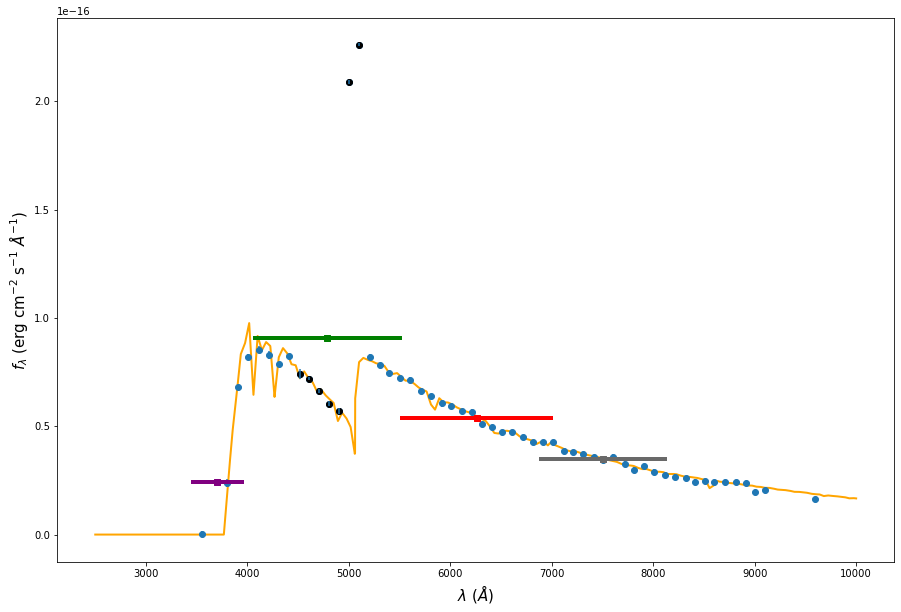

AGE: 0.004195330988798611, MET: 34.327853918941734, EXT: 0.0879370404736084
z = 3.163193040278662
EW0 = 77.40919893456993
L = 44.22896095392747


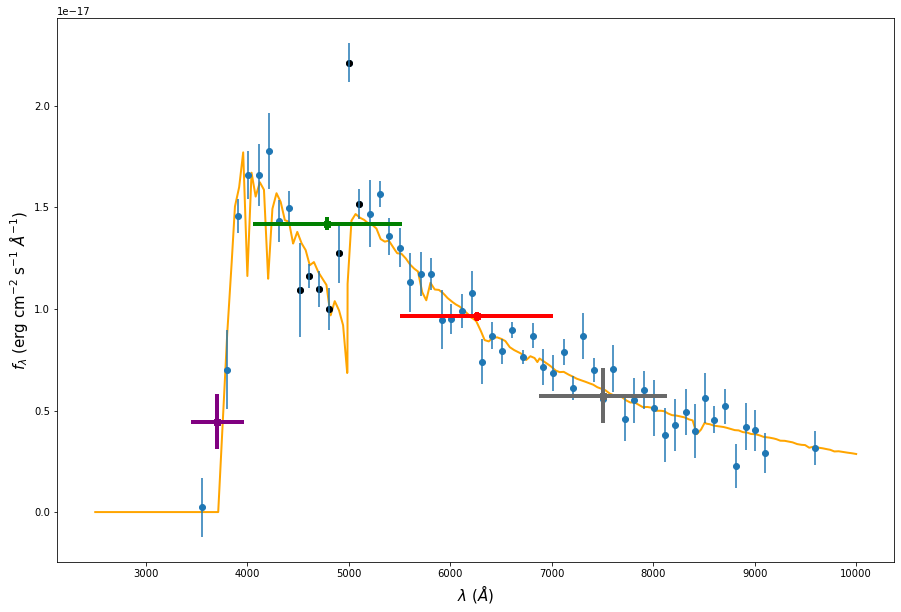

AGE: 0.0045378191305187835, MET: 33.44272086707856, EXT: 0.08586189691261395
z = 3.1016910556151096
EW0 = 28.803942591540995
L = 43.36054406632479


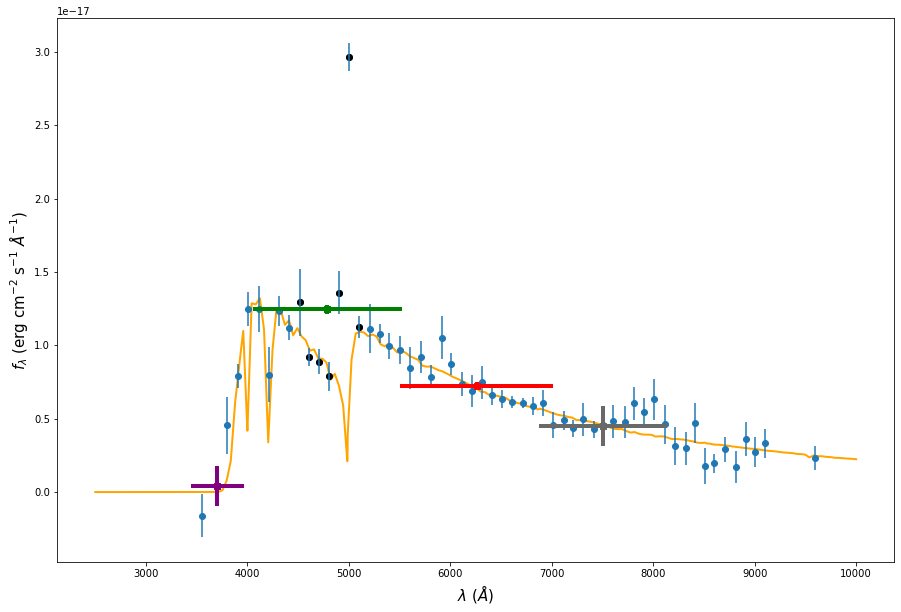

AGE: 0.04483574854428349, MET: 22.635997447605668, EXT: 0.019389556958148965
z = 3.102324716970195
EW0 = 122.28117623571336
L = 43.359245311961416


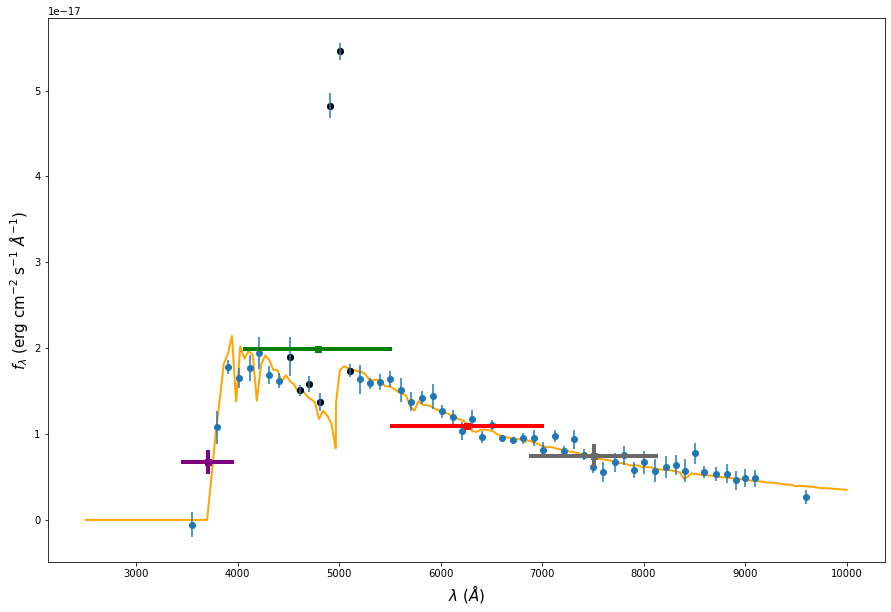

AGE: 0.0048270596739626, MET: 33.731292586029184, EXT: 0.08488400039708095
z = 3.0853462026265523
EW0 = 85.61026378285275
L = 43.35522094725914


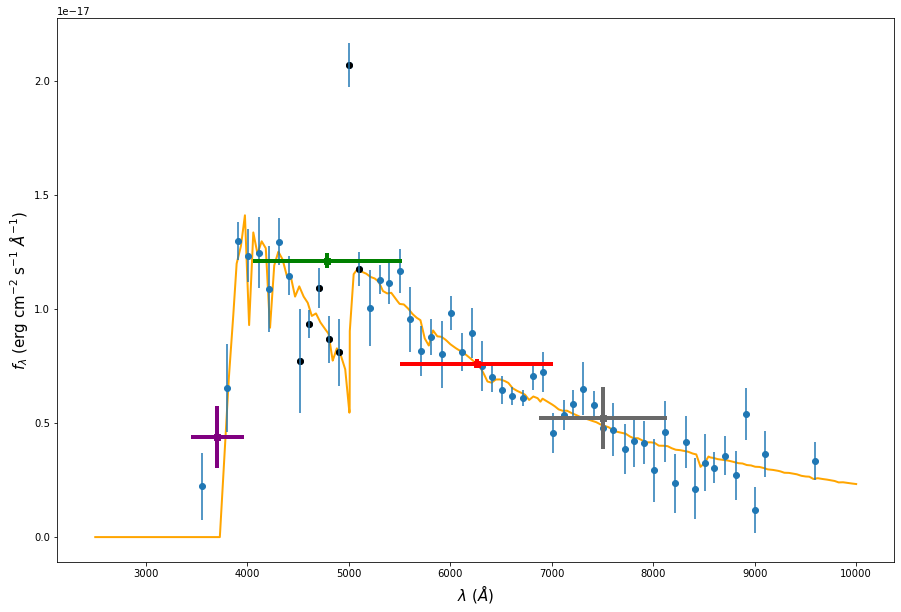

AGE: 0.004543168776815313, MET: 33.12388263585249, EXT: 0.08723146152219063
z = 3.119467731999329
EW0 = 34.83766574256018
L = 43.87905004409714


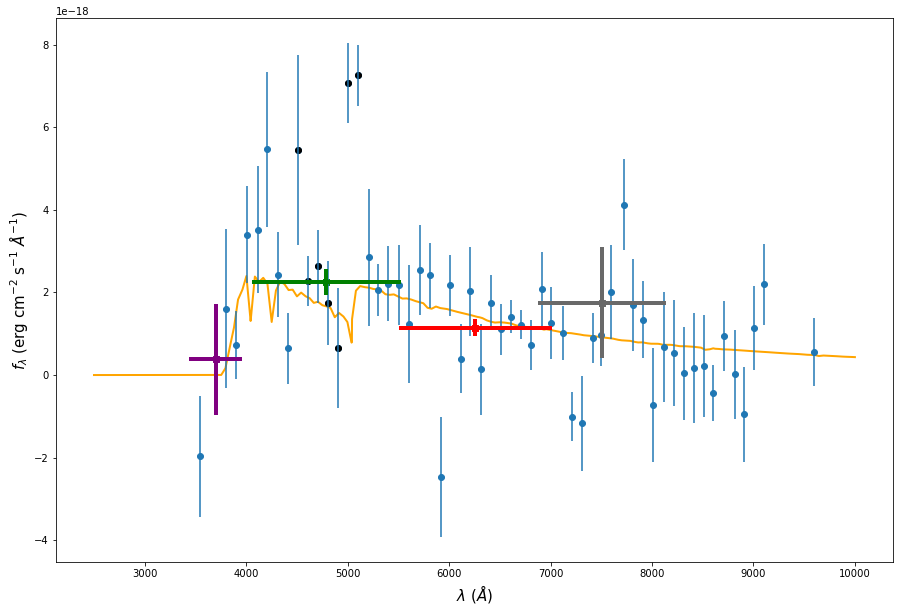

AGE: 0.014226461353707821, MET: 24.77886341387265, EXT: 0.077737891815392
z = 3.147515136489332
EW0 = 114.5434159974488
L = 43.46672692198578


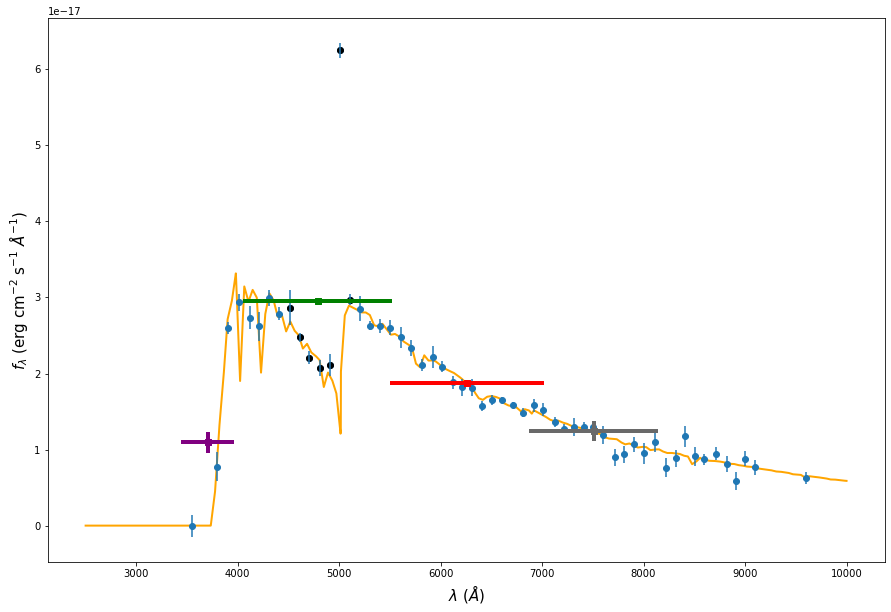

AGE: 0.008719353525836486, MET: 33.78586539823052, EXT: 0.07513033396990729
z = 3.125500833985089
EW0 = 61.054888359961865
L = 43.873470786665465


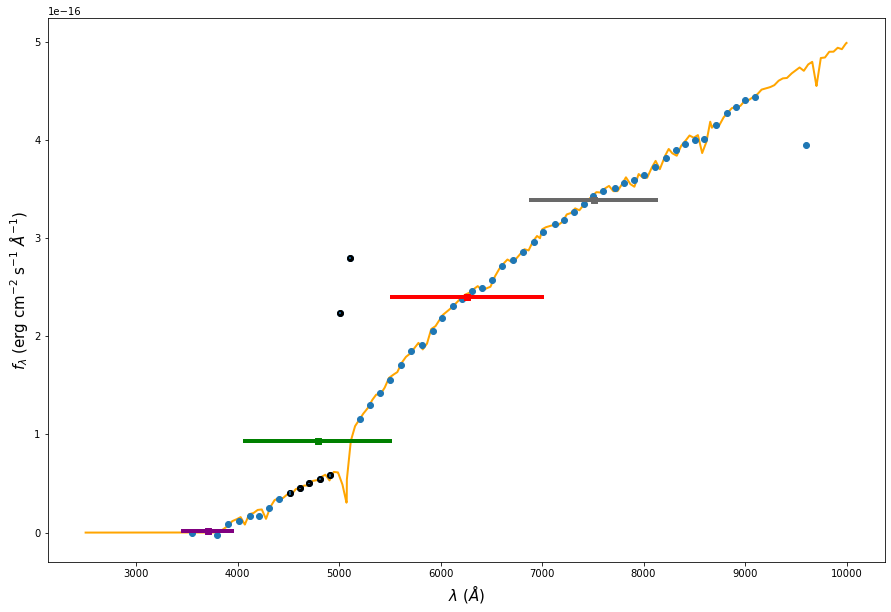

AGE: 0.01616058840437125, MET: 30.822129334904808, EXT: 0.9423949572767055
z = 3.173698627821893
EW0 = 94.0137794094459
L = 43.41154563439038


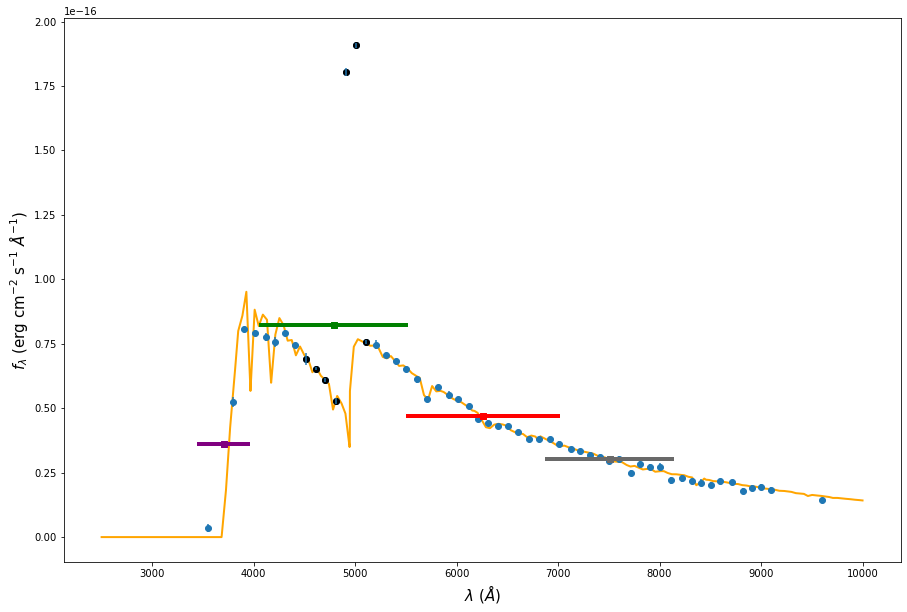

AGE: 0.006168573843268068, MET: 35.22744314487436, EXT: 0.05446079773445624
z = 3.0689829784811824
EW0 = 69.07636609640889
L = 43.40133084757504


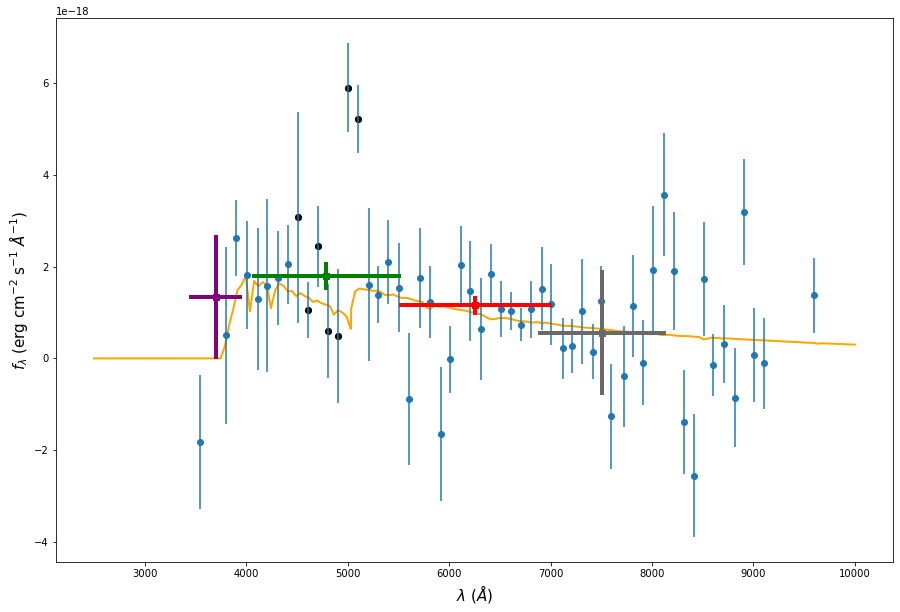

AGE: 0.008067320938667, MET: 34.397035184031104, EXT: 0.06200554634064545
z = 3.140473665049242
EW0 = 126.5410121723356
L = 43.865488123261386


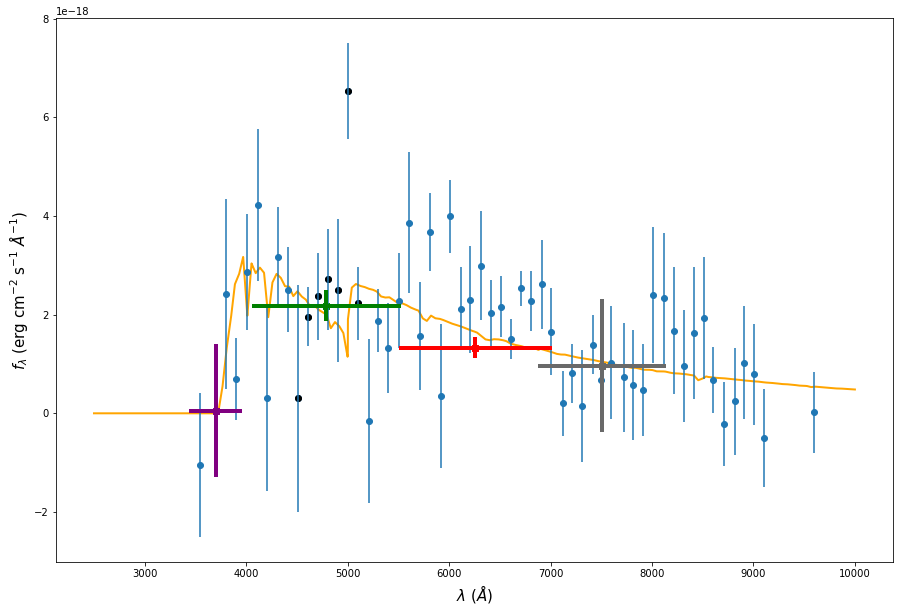

AGE: 0.007617473891601248, MET: 30.403090223699852, EXT: 0.061527218012067036
z = 3.114405923445463
EW0 = 45.26638205594226
L = 43.41484024581857


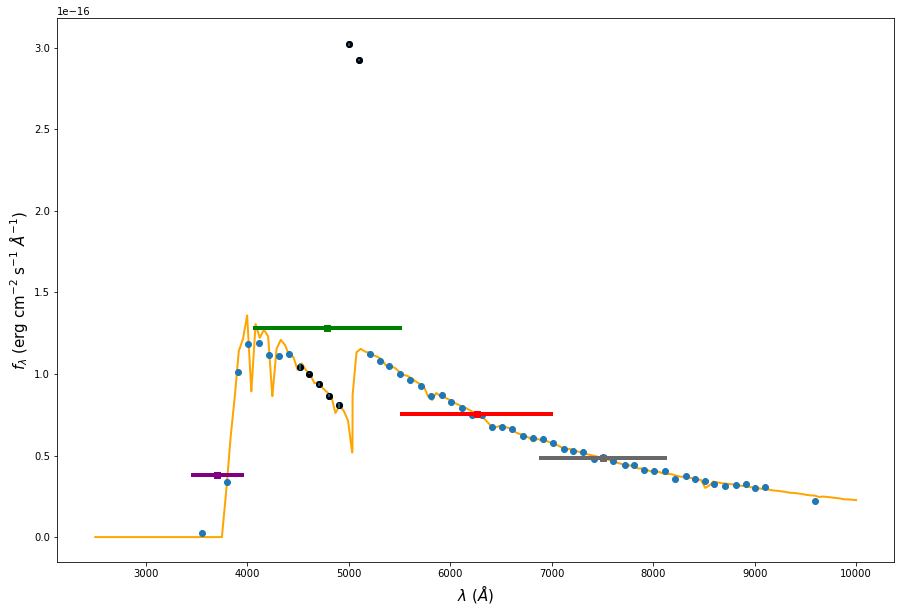

AGE: 0.006310721592627507, MET: 26.548805654676276, EXT: 0.08577375057467215
z = 3.1420463752620775
EW0 = 78.44763727105634
L = 44.776385823005704


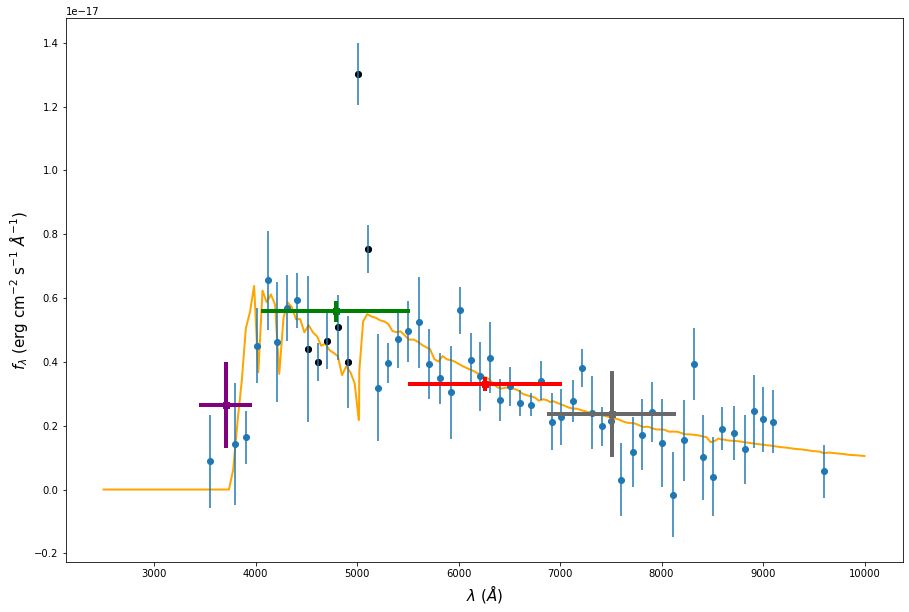

AGE: 0.011512842265957073, MET: 27.430339393278885, EXT: 0.06617626847691833
z = 3.127816294726867
EW0 = 72.83490724558392
L = 43.55052126085636


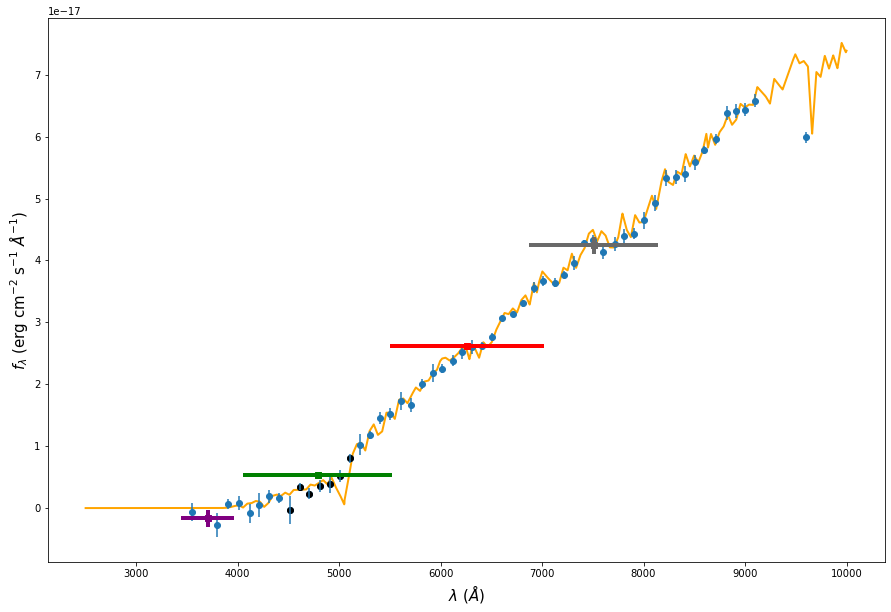

AGE: 0.052821963935960795, MET: 51.18574125244, EXT: 0.9747288801413553
z = 3.15530304092565
EW0 = 22.02660713869971
L = 44.101326246571446


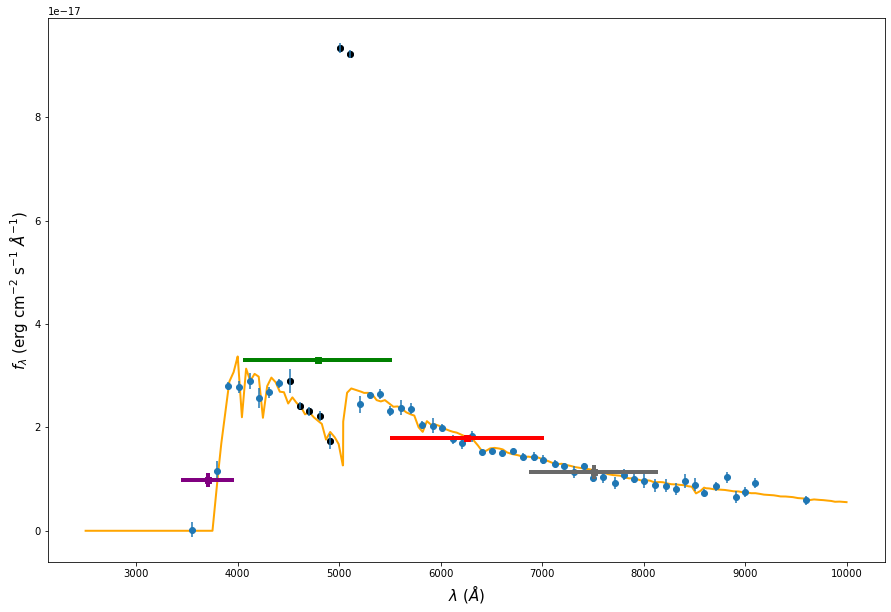

AGE: 0.004123765737607544, MET: 35.92256437175864, EXT: 0.07887591751078914
z = 3.1440549909140483
EW0 = 110.53826011248114
L = 43.348759450704065


In [11]:
for mock_n in range(30):
    
#     if mock['LAE'][mock_n] == True:
#         continue

    pm = photo(mock_n)
    
    plt.figure(figsize=(15,10))
    plt.plot( mock['w_Arr'], mock['SEDs_no_line'][mock_n], c='orange', lw=2, zorder=-1)
    plt.scatter(w_central[:-3], pm[:-3])
    plt.errorbar(w_central[:-3], pm[:-3], yerr=errors[:-3], fmt='none')
    plt.scatter(w_central[8:15], pm[8:15], c='black')
    
    plt.scatter(w_central[-4], pm[-4], c='purple' , marker='s')
    plt.scatter(w_central[-3], pm[-3], c='green'  , marker='s')
    plt.scatter(w_central[-2], pm[-2], c='red'    , marker='s')
    plt.scatter(w_central[-1], pm[-1], c='dimgray', marker='s')
    
    plt.errorbar(w_central[-4], pm[-4], xerr=bb_fwhm[-4]/2, yerr= errors[-4],
    fmt='none', color='purple' , elinewidth=4)
    plt.errorbar(w_central[-3], pm[-3], xerr=bb_fwhm[-3]/2, yerr= errors[-3],
     fmt='none', color='green'  , elinewidth=4)
    plt.errorbar(w_central[-2], pm[-2], xerr=bb_fwhm[-2]/2, yerr= errors[-2],
     fmt='none', color='red'    , elinewidth=4)
    plt.errorbar(w_central[-1], pm[-1], xerr=bb_fwhm[-1]/2, yerr= errors[-4],
     fmt='none', color='dimgray', elinewidth=4)
    
    #plt.yscale('log')
    
    plt.xlabel('$\lambda\ (\AA)$', size=15)
    plt.ylabel('$f_\lambda$ (erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$)', size=15)
    
    plt.show()
    
    if mock['LAE'][mock_n]:
        print('AGE: {}, MET: {}, EXT: {}'\
              .format(mock['AGE'][mock_n], mock['MET'][mock_n], mock['EXT'][mock_n]))
    
    print('z = ' + str(mock['redshift_Lya_Arr'][mock_n]))
    print('EW0 = ' + str(mock['EW_Arr'][mock_n]))
    print('L = ' + str(mock['L_line'][mock_n]))

In [12]:
mock.keys()

dict_keys(['SEDs', 'SEDs_no_IGM', 'SEDs_no_line', 'w_Arr', 'LAE', 'EW_Arr', 'redshift_Lya_Arr', 'AGE', 'MET', 'EXT', 'L_line'])